# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [ ]:
# !pip install --upgrade --no-cache-dir gdown

# !gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
# !gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

# !unzip -q lab2.zip
# !unzip -q train_librispeech_10h.zip
# !mv lab2 lab3
# !mv train_librispeech_10h lab3/data
# !rm -rf lab2.zip sample_data train_librispeech_10h.zip
# %cd lab3

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 186MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:15<00:00, 44.2MB/s]
/content/lab3


In [1]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(y=x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)   # {фонема: id}

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)    # {имя_файла: список произнесенных фонем}

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)  # {имя_файла: mfcc-признаки}

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

http://data-science.wiki/images/Automatic_Speech_Recognition_RxtNVMXYTy.pdf

In [3]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]   # mfcc-признаки
        file_ali = ali_dict[file_name]       # список произнесенных фонем
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = None
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [4]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)
            

In [5]:
class MyNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet, self).__init__()
        # params:
        ff_dim = 256

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = ', device)
print()

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    with torch.no_grad():
        nnet.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
        val_out = nnet(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

device =  cuda

TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.4531
val loss is: 2.2607


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.2431
val loss is: 2.2142


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.2061
val loss is: 2.1886


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.1800
val loss is: 2.1673


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.1597
val loss is: 2.1513


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.1436
val loss is: 2.1422


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.1307
val loss is: 2.1360


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.1202
val loss is: 2.1278


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.1112
val loss is: 2.1195


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.1035
val loss is: 2.1133
Time is: 0 min 59 sec


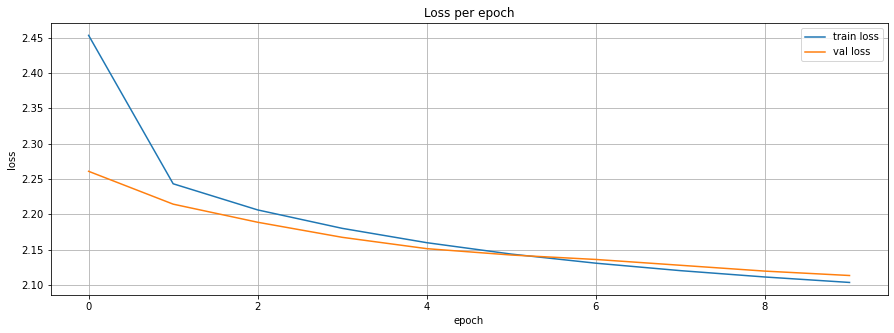

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [8]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.411

SIL: 0.95 : 21649/22671
SPN: 0.00 : 0/634
AA0: 0.00 : 0/33
AA1: 0.33 : 607/1861
AA2: 0.00 : 0/93
AE0: 0.00 : 0/40
AE1: 0.46 : 1670/3611
AE2: 0.00 : 0/91
AH0: 0.28 : 1615/5669
AH1: 0.24 : 510/2098
AH2: 0.00 : 0/41
AO0: 0.00 : 0/27
AO1: 0.37 : 754/2034
AO2: 0.02 : 1/41
AW0: 0.00 : 0/11
AW1: 0.06 : 71/1121
AW2: 0.00 : 0/47
AY0: 0.00 : 0/47
AY1: 0.15 : 467/3033
AY2: 0.00 : 0/190
B  : 0.20 : 310/1564
CH : 0.00 : 1/892
D  : 0.16 : 638/3957
DH : 0.04 : 72/1994
EH0: 0.00 : 0/47
EH1: 0.15 : 425/2839
EH2: 0.00 : 0/92
ER0: 0.23 : 578/2501
ER1: 0.12 : 104/887
ER2: 0.00 : 0/9
EY0: 0.00 : 0/25
EY1: 0.46 : 1056/2278
EY2: 0.00 : 0/149
F  : 0.36 : 827/2328
G  : 0.00 : 1/797
HH : 0.22 : 465/2159
IH0: 0.07 : 191/2723
IH1: 0.13 : 300/2311
IH2: 0.00 : 0/100
IY0: 0.11 : 255/2221
IY1: 0.64 : 1529/2386
IY2: 0.00 : 0/73
JH : 0.06 : 41/696
K  : 0.23 : 712/3050
L  : 0.57 : 2389/4227
M  : 0.26 : 857/3328
N  : 0.57 : 3382/5978
NG : 0.09 : 125/1368
OW0: 0.00 : 0/203
OW1: 0.13 : 253/18

### Распознавание по словарю с помощью нейронной сети

In [9]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [177]:
EPS = 1e-8

class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet, norm=False):
        with torch.no_grad():
            if norm:
                input_feats = torch.from_numpy(np.array([input_feats])).float()
                predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
                predicts = predicts[0]
                softmax = torch.nn.functional.softmax(predicts, dim=0)
                return -np.log(softmax[self.phone_index].item() / (self.phone_prior + EPS))
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
            
        return -np.log(softmax[self.phone_index].item() / (self.phone_prior + EPS))

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [11]:
# --------  MY CODE HERE ----------------

def features_with_context(frame, file_feats, length, side_context=None):
    '''Добавляем контекст слева и справа от кадра frame длины side_context'''
    if side_context is None:
        feature = file_feats[frame]
    else:
        if frame - side_context < 0:   # вылезаем влево за нулевой индекс
            count_double = abs(frame - side_context)
            feature = file_feats[max(0, frame - side_context): frame + side_context + 1].ravel()
            feature = np.concatenate((np.tile(file_feats[0], count_double), feature))
        elif frame + side_context >= length:  # вылезаем вправо за последний индекс
            count_double = frame + side_context - length + 1
            feature = file_feats[frame - side_context: min(frame + side_context + 1, length)].ravel()
            #feature = file_feats[frame - side_context: ].ravel()
            feature = np.concatenate((feature, np.tile(file_feats[-1], count_double)))
        else:
            feature = file_feats[frame - side_context: frame + side_context + 1].ravel()
    return feature

In [164]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, side_context, beam_threshold, norm):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    len_features = len(features)
    for frame in range(len_features):
        #ftr_frame = features[frame]
        # ----------- my code here ---------------------------------
        ftr_frame = features_with_context(frame, features, len_features, side_context)
        # ----------------------------------------------------------
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet, norm)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [165]:
def run_recognizer(records_data_dict, graph, nnet, side_context=None, beam_threshold=10, norm=False):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results,
                                        side_context,
                                        beam_threshold,
                                        norm)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [14]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> NO
result: yes_fc94edb0_nohash_0       ==> NO
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 30.00%
Total time is: 0.30 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> NO
result: yes_fc94edb0_nohash_0       ==> NO
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0   

### Запустим распознавание на базе Digits

In [15]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

Beam = 1

result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> FOUR
result: nine_ccea893d_nohash_0      ==> TWO
result: zero_f92e49f3_nohash_3      ==> TWO
result: four_ffbb695d_nohash_0      ==> TWO
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FOUR
result: three_fce96bac_nohash_0     ==> FOUR
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> TWO
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> ZERO
result: zero_f852895b_nohash_0      ==> THREE
result: one_fc2411fe_nohash_0       ==> NINE
result: one_ffa76c4a_nohash_0       ==> FIVE
result: seven_fd32732a_nohash_0     ==> TWO
result: two_fce65496_nohash_0       ==> ONE
------------------------------------------------------------
WER is: 80.00%
Total time is: 0.9

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

In [16]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]   # mfcc-признаки
        file_ali = ali_dict[file_name]       # список произнесенных фонем
        length = min(len(file_feats), len(file_ali))
        for frame in range(length):
            priors_list[phones_dict[file_ali[frame]]] += 1
            feature = features_with_context(frame, file_feats, length, side_context=side_context)
            feature = np.append(feature, phones_dict[file_ali[frame]])
            data_list.append(feature)         
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = 2
data_list_context, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list_context = np.random.permutation(data_list_context)

In [17]:
data_list_context.shape

(1283148, 66)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
nnet_context = MyNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet_context.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet_context(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.2381


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8667


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7845


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7314


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6928


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6625


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6380


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6174


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5997


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5842
Time is: 0 min 58 sec


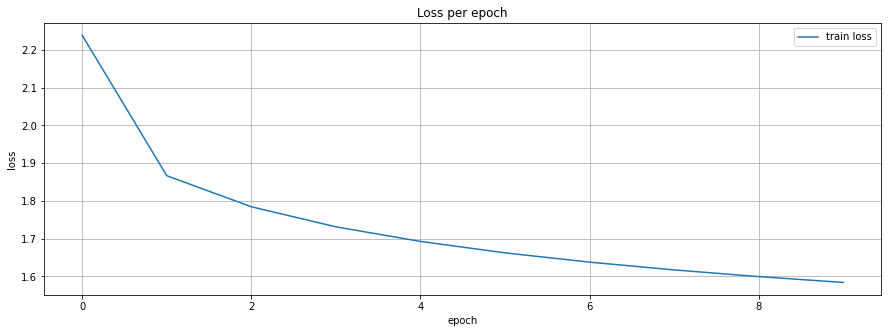

In [34]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [35]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet_context.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet_context.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.531

SIL: 0.96 : 21763/22770
SPN: 0.00 : 0/672
AA0: 0.00 : 0/38
AA1: 0.53 : 996/1882
AA2: 0.00 : 0/94
AE0: 0.00 : 0/50
AE1: 0.51 : 1885/3677
AE2: 0.00 : 0/92
AH0: 0.40 : 2255/5626
AH1: 0.22 : 421/1940
AH2: 0.00 : 0/36
AO0: 0.00 : 0/36
AO1: 0.46 : 905/1957
AO2: 0.00 : 0/37
AW0: 0.00 : 0/10
AW1: 0.30 : 328/1107
AW2: 0.02 : 1/44
AY0: 0.00 : 0/50
AY1: 0.57 : 1749/3052
AY2: 0.00 : 0/171
B  : 0.24 : 366/1528
CH : 0.22 : 193/877
D  : 0.25 : 984/3992
DH : 0.39 : 811/2063
EH0: 0.00 : 0/57
EH1: 0.30 : 854/2844
EH2: 0.00 : 0/112
ER0: 0.36 : 906/2491
ER1: 0.16 : 145/885
ER2: 0.00 : 0/11
EY0: 0.00 : 0/26
EY1: 0.50 : 1152/2293
EY2: 0.01 : 1/143
F  : 0.62 : 1450/2341
G  : 0.15 : 116/764
HH : 0.41 : 883/2155
IH0: 0.18 : 468/2617
IH1: 0.29 : 663/2312
IH2: 0.00 : 0/113
IY0: 0.41 : 927/2279
IY1: 0.47 : 1123/2415
IY2: 0.00 : 0/77
JH : 0.14 : 92/639
K  : 0.47 : 1452/3067
L  : 0.54 : 2253/4184
M  : 0.47 : 1504/3180
N  : 0.62 : 3793/6095
NG : 0.34 : 470/1379
OW0: 0.00 : 0/176
OW1: 0

In [36]:
side_context

2

## yes_no

In [37]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, nnet_context.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.39 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_noh

## digits

In [38]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, nnet_context.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

Beam = 1

result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: nine_ccea893d_nohash_0      ==> THREE
result: zero_f92e49f3_nohash_3      ==> FOUR
result: four_ffbb695d_nohash_0      ==> FOUR
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> FIVE
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> SEVEN
result: nine_fbe51750_nohash_0      ==> THREE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> THREE
result: one_fc2411fe_nohash_0       ==> ONE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> THREE
result: two_fce65496_nohash_0       ==> FIVE
------------------------------------------------------------
WER is: 65.00%
Total time 

### **Ответ**:

Точность на валидации:  
было: 0.411  
стало: 0.531

Качество на датасетах:  
***Yes_no***  
**1) beam = 1**
* Baseline:
   * WER = 30%  
   * Время = 0.30 сек
* side_context = 2:
   * WER = 20%
   * Время = 0.39 сек
   
**2) beam = 3**
* Baseline:
   * WER = 30%  
   * Время = 0.26 сек
* side_context = 2:
   * WER = 10%
   * Время = 0.37 сек

**3) beam = 5**
* Baseline:
   * WER = 10%  
   * Время = 0.56 сек
* side_context = 2:
   * WER = 0%
   * Время = 0.34 сек
   
**4) beam = 10**
* Baseline:
   * WER = 10%  
   * Время = 0.54 сек
* side_context = 2:
   * WER = 0%
   * Время = 0.46 сек
   
**5) beam = 20**
* Baseline:
   * WER = 0%  
   * Время = 0.67 сек
* side_context = 2:
   * WER = 0%
   * Время = 0.65 сек   

   
***Digits***  
**1) beam = 1**
* Baseline:
   * WER = 80%  
   * Время = 0.98 сек
* side_context = 2:
   * WER = 65%
   * Время = 1.13 сек
   
**2) beam = 5**
* Baseline:
   * WER = 55%  
   * Время = 2.29 сек
* side_context = 2:
   * WER = 55%
   * Время = 1.92 сек
   
**3) beam = 10**
* Baseline:
   * WER = 55%  
   * Время = 3.49 сек
* side_context = 2:
   * WER = 25%
   * Время = 3.61 сек
   
**4) beam = 20**
* Baseline:
   * WER = 35%  
   * Время = 6.36 сек
* side_context = 2:
   * WER = 10%
   * Время = 5.52 сек
   
**5) beam = 30**
* Baseline:
   * WER = 30%  
   * Время = 7.27 сек
* side_context = 2:
   * WER = 10%
   * Время = 6.99 сек
   
**6) beam = 50**
* Baseline:
   * WER = 25%  
   * Время = 9.46 сек
* side_context = 2:
   * WER = 15%
   * Время = 7.99 сек

Видно, что добавление контекста существенно улучшает качество распознавания. Для датасета `yes_no` можно использовать порог beam = 5, а для `digits` порог beam = 20.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, расписания скорости обучения, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

Попробуем улучшить результат п. 1

# MyNewNNet + Adam

In [51]:
class MyNewNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNewNNet, self).__init__()
        # params:

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
new_nnet_context = MyNewNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_nnet_context.parameters(), lr=0.0001)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = new_nnet_context(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    with torch.no_grad():
        new_nnet_context.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
#         val_data, true_lavel = data_set.valid[:, :-1], data_set.valid[:, -1]
        val_out = new_nnet_context(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.0565
val loss is: 1.8486


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7948
val loss is: 1.7445


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7178
val loss is: 1.6879


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6686
val loss is: 1.6526


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6329
val loss is: 1.6267


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6050
val loss is: 1.6064


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5822
val loss is: 1.5908


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5630
val loss is: 1.5773


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5468
val loss is: 1.5664


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5326
val loss is: 1.5568
Time is: 1 min 12 sec


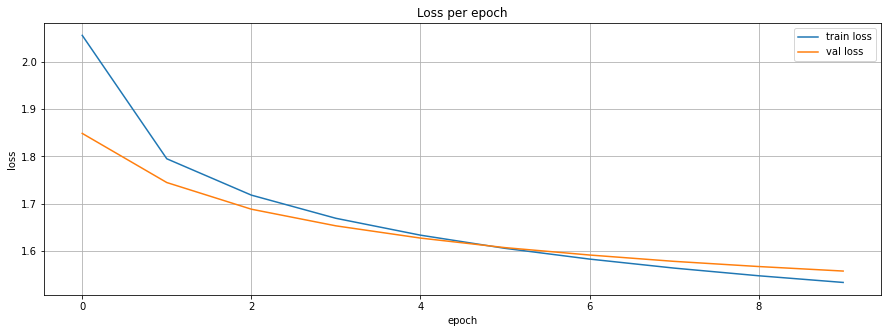

In [56]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [57]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

new_nnet_context.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = new_nnet_context.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.541

SIL: 0.96 : 21772/22770
SPN: 0.00 : 1/672
AA0: 0.00 : 0/38
AA1: 0.55 : 1031/1882
AA2: 0.00 : 0/94
AE0: 0.00 : 0/50
AE1: 0.55 : 2005/3677
AE2: 0.00 : 0/92
AH0: 0.42 : 2366/5626
AH1: 0.22 : 429/1940
AH2: 0.00 : 0/36
AO0: 0.00 : 0/36
AO1: 0.47 : 924/1957
AO2: 0.00 : 0/37
AW0: 0.00 : 0/10
AW1: 0.33 : 370/1107
AW2: 0.02 : 1/44
AY0: 0.00 : 0/50
AY1: 0.56 : 1711/3052
AY2: 0.00 : 0/171
B  : 0.24 : 374/1528
CH : 0.25 : 223/877
D  : 0.26 : 1022/3992
DH : 0.41 : 836/2063
EH0: 0.00 : 0/57
EH1: 0.31 : 873/2844
EH2: 0.00 : 0/112
ER0: 0.41 : 1032/2491
ER1: 0.16 : 139/885
ER2: 0.00 : 0/11
EY0: 0.00 : 0/26
EY1: 0.56 : 1282/2293
EY2: 0.01 : 1/143
F  : 0.64 : 1488/2341
G  : 0.15 : 115/764
HH : 0.44 : 950/2155
IH0: 0.18 : 472/2617
IH1: 0.30 : 696/2312
IH2: 0.00 : 0/113
IY0: 0.40 : 906/2279
IY1: 0.51 : 1223/2415
IY2: 0.00 : 0/77
JH : 0.18 : 117/639
K  : 0.50 : 1544/3067
L  : 0.51 : 2137/4184
M  : 0.50 : 1581/3180
N  : 0.61 : 3720/6095
NG : 0.33 : 449/1379
OW0: 0.01 : 1/176
OW

На валидации качество выросло

## yes_no

In [58]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, new_nnet_context.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 30.00%
Total time is: 0.29 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_noha

## Digits

In [59]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, new_nnet_context.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1

result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> FIVE
result: nine_ccea893d_nohash_0      ==> FOUR
result: zero_f92e49f3_nohash_3      ==> THREE
result: four_ffbb695d_nohash_0      ==> THREE
result: three_feb1d305_nohash_0     ==> FOUR
result: five_ffd2ba2f_nohash_0      ==> FOUR
result: three_fce96bac_nohash_0     ==> FIVE
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> SEVEN
result: nine_fbe51750_nohash_0      ==> ONE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> FIVE
result: one_fc2411fe_nohash_0       ==> ONE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> TWO
result: two_fce65496_nohash_0       ==> TWO
------------------------------------------------------------
WER is: 80.00%
Total time is: 

Улучшения на датасетах нет

# MyNewNNet + Adam + ReduceLROnPlateau

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
new_nnet_context_sched = MyNewNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_nnet_context_sched.parameters(), lr=0.003)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(50):
    new_nnet_context_sched.train()
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = new_nnet_context_sched(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
    
    with torch.no_grad():
        new_nnet_context_sched.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
#         val_data, true_lavel = data_set.valid[:, :-1], data_set.valid[:, -1]
        val_out = new_nnet_context_sched(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    lr_scheduler.step(val_l)
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.9472
val loss is: 1.8432


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8358
val loss is: 1.8360


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8227
val loss is: 1.8106


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8156
val loss is: 1.8070


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8075
val loss is: 1.8160


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8030
val loss is: 1.8047


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8026
val loss is: 1.7929


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7995
val loss is: 1.8180


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7997
val loss is: 1.7845


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7954
val loss is: 1.7822


epoch 10:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7940
val loss is: 1.7793


epoch 11:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7911
val loss is: 1.7825


epoch 12:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7901
val loss is: 1.7794


epoch 13:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7893
val loss is: 1.7762


epoch 14:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7849
val loss is: 1.7855


epoch 15:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7850
val loss is: 1.7931


epoch 16:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7832
val loss is: 1.7989


epoch 17:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7813
val loss is: 1.7794


epoch 18:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7813
val loss is: 1.7887


epoch 19:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7820
val loss is: 1.7841


epoch 20:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7801
val loss is: 1.7812


epoch 21:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7836
val loss is: 1.7749


epoch 22:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7822
val loss is: 1.7727


epoch 23:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7794
val loss is: 1.7713


epoch 24:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7799
val loss is: 1.7746


epoch 25:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7821
val loss is: 1.7865


epoch 26:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7794
val loss is: 1.7906


epoch 27:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7808
val loss is: 1.7798


epoch 28:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7823
val loss is: 1.7783


epoch 29:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7772
val loss is: 1.7774


epoch 30:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7788
val loss is: 1.7748


epoch 31:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7776
val loss is: 1.7842


epoch 32:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7750
val loss is: 1.7816


epoch 33:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7766
val loss is: 1.7745


epoch 34:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7779
val loss is: 1.7749


epoch 35:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6535
val loss is: 1.6542


epoch 36:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6293
val loss is: 1.6429


epoch 37:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6202
val loss is: 1.6376


epoch 38:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6149
val loss is: 1.6325


epoch 39:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6110
val loss is: 1.6291


epoch 40:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6078
val loss is: 1.6282


epoch 41:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6053
val loss is: 1.6265


epoch 42:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6030
val loss is: 1.6257


epoch 43:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6011
val loss is: 1.6239


epoch 44:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5994
val loss is: 1.6229


epoch 45:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5978
val loss is: 1.6218


epoch 46:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5966
val loss is: 1.6213


epoch 47:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5952
val loss is: 1.6211


epoch 48:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5939
val loss is: 1.6200


epoch 49:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5928
val loss is: 1.6195
Time is: 6 min 0 sec


In [83]:
optimizer.param_groups[0]['lr']

0.00030000000000000003

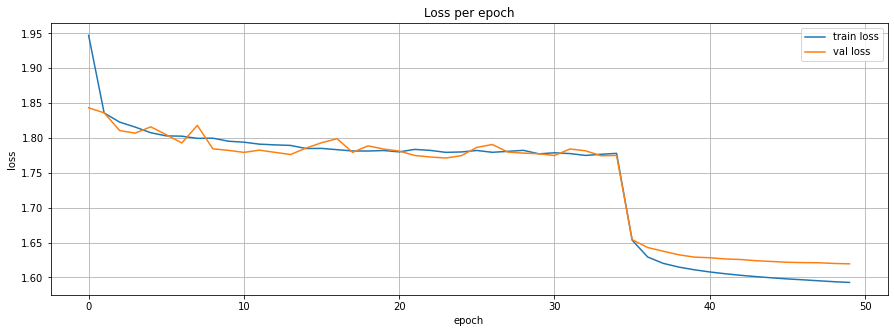

In [84]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [85]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

new_nnet_context_sched.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = new_nnet_context_sched.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.528



## yes_no

In [94]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, new_nnet_context_sched.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES


/tmp/ipykernel_375/259245042.py:13: RuntimeWarning: divide by zero encountered in log
  return -np.log(softmax[self.phone_index].item() / (self.phone_prior + EPS))


result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.30 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> NO
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 10.00%
Total time is: 0.29 sec
----------------------

## Digits

In [87]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, new_nnet_context_sched.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1

result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> TWO
result: nine_ccea893d_nohash_0      ==> TWO
result: zero_f92e49f3_nohash_3      ==> THREE
result: four_ffbb695d_nohash_0      ==> THREE
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FOUR
result: three_fce96bac_nohash_0     ==> ONE
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> FIVE
result: nine_fbe51750_nohash_0      ==> FOUR
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> FIVE
result: one_fc2411fe_nohash_0       ==> ONE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> TWO
result: two_fce65496_nohash_0       ==> ONE
------------------------------------------------------------
WER is: 80.00%
Total time is: 1.

# MyNNet + Adam + ReduceLROnPlateau

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
nnet_context_sched = MyNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet_context_sched.parameters(), lr=0.0005)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(80):
    nnet_context_sched.train()
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet_context_sched(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
    
    with torch.no_grad():
        nnet_context_sched.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
#         val_data, true_lavel = data_set.valid[:, :-1], data_set.valid[:, -1]
        val_out = nnet_context_sched(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    lr_scheduler.step(val_l)
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.0166
val loss is: 1.7682


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7188
val loss is: 1.6748


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6506
val loss is: 1.6298


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6119
val loss is: 1.6042


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5871
val loss is: 1.5879


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5696
val loss is: 1.5823


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5568
val loss is: 1.5766


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5464
val loss is: 1.5715


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5382
val loss is: 1.5729


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5310
val loss is: 1.5674


epoch 10:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5252
val loss is: 1.5660


epoch 11:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5202
val loss is: 1.5643


epoch 12:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5157
val loss is: 1.5652


epoch 13:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5121
val loss is: 1.5653


epoch 14:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5088
val loss is: 1.5615


epoch 15:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5060
val loss is: 1.5621


epoch 16:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5035
val loss is: 1.5597


epoch 17:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5006
val loss is: 1.5609


epoch 18:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4982
val loss is: 1.5634


epoch 19:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4967
val loss is: 1.5571


epoch 20:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4951
val loss is: 1.5590


epoch 21:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4929
val loss is: 1.5574


epoch 22:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4916
val loss is: 1.5593


epoch 23:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4900
val loss is: 1.5518


epoch 24:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4884
val loss is: 1.5584


epoch 25:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4875
val loss is: 1.5550


epoch 26:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4861
val loss is: 1.5579


epoch 27:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4855
val loss is: 1.5503


epoch 28:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4844
val loss is: 1.5515


epoch 29:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4834
val loss is: 1.5533


epoch 30:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4830
val loss is: 1.5532


epoch 31:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4816
val loss is: 1.5543


epoch 32:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4811
val loss is: 1.5518


epoch 33:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4802
val loss is: 1.5480


epoch 34:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4800
val loss is: 1.5530


epoch 35:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4790
val loss is: 1.5485


epoch 36:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4789
val loss is: 1.5477


epoch 37:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4783
val loss is: 1.5504


epoch 38:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4781
val loss is: 1.5545


epoch 39:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4773
val loss is: 1.5486


epoch 40:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4764
val loss is: 1.5553


epoch 41:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4766
val loss is: 1.5565


epoch 42:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4767
val loss is: 1.5584


epoch 43:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4753
val loss is: 1.5526


epoch 44:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4754
val loss is: 1.5517


epoch 45:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4756
val loss is: 1.5537


epoch 46:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4754
val loss is: 1.5526


epoch 47:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4749
val loss is: 1.5556


epoch 48:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4049
val loss is: 1.4985


epoch 49:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3899
val loss is: 1.4958


epoch 50:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3849
val loss is: 1.4943


epoch 51:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3818
val loss is: 1.4935


epoch 52:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3798
val loss is: 1.4936


epoch 53:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3781
val loss is: 1.4940


epoch 54:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3767
val loss is: 1.4936


epoch 55:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3755
val loss is: 1.4937


epoch 56:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3744
val loss is: 1.4940


epoch 57:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3735
val loss is: 1.4957


epoch 58:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3726
val loss is: 1.4953


epoch 59:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3720
val loss is: 1.4962


epoch 60:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3712
val loss is: 1.4958


epoch 61:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3706
val loss is: 1.4975


epoch 62:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3699
val loss is: 1.4957


epoch 63:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3626
val loss is: 1.4908


epoch 64:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3608
val loss is: 1.4906


epoch 65:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3603
val loss is: 1.4906


epoch 66:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3600
val loss is: 1.4905


epoch 67:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3597
val loss is: 1.4907


epoch 68:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3595
val loss is: 1.4907


epoch 69:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3593
val loss is: 1.4907


epoch 70:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3592
val loss is: 1.4907


epoch 71:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3590
val loss is: 1.4908


epoch 72:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3589
val loss is: 1.4909


epoch 73:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3587
val loss is: 1.4909


epoch 74:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3586
val loss is: 1.4910


epoch 75:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3585
val loss is: 1.4908


epoch 76:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3576
val loss is: 1.4898


epoch 77:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3574
val loss is: 1.4897


epoch 78:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3573
val loss is: 1.4896


epoch 79:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3572
val loss is: 1.4896
Time is: 7 min 56 sec


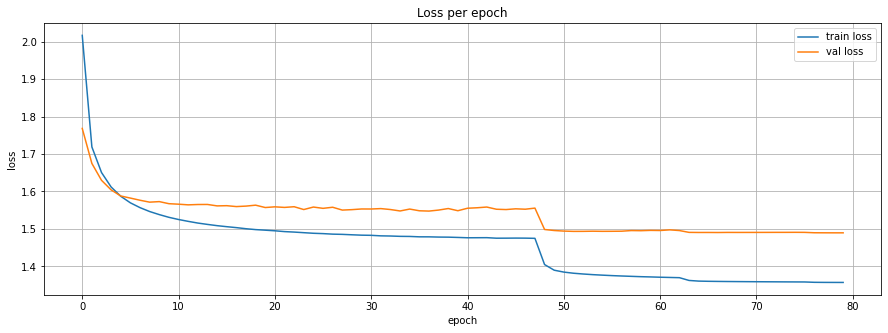

In [116]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [117]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet_context_sched.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet_context_sched.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.565



## yes_no

In [118]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, nnet_context_sched.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> NO
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES


/tmp/ipykernel_375/259245042.py:13: RuntimeWarning: divide by zero encountered in log
  return -np.log(softmax[self.phone_index].item() / (self.phone_prior + EPS))


result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.29 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.25 sec
----------------------

## Digits

In [119]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, nnet_context_sched.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1

result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> TWO
result: nine_ccea893d_nohash_0      ==> TWO
result: zero_f92e49f3_nohash_3      ==> THREE
result: four_ffbb695d_nohash_0      ==> THREE
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FOUR
result: three_fce96bac_nohash_0     ==> FIVE
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> FIVE
result: nine_fbe51750_nohash_0      ==> ONE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> THREE
result: one_fc2411fe_nohash_0       ==> ONE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> THREE
result: two_fce65496_nohash_0       ==> TWO
------------------------------------------------------------
WER is: 75.00%
Total time is:

/tmp/ipykernel_375/259245042.py:13: RuntimeWarning: divide by zero encountered in log
  return -np.log(softmax[self.phone_index].item() / (self.phone_prior + EPS))


result: four_fce65496_nohash_0      ==> ONE
result: nine_ccea893d_nohash_0      ==> ONE
result: zero_f92e49f3_nohash_3      ==> ONE
result: four_ffbb695d_nohash_0      ==> THREE
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FOUR
result: three_fce96bac_nohash_0     ==> ZERO
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> SIX
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> THREE
result: one_fc2411fe_nohash_0       ==> ONE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: two_fce65496_nohash_0       ==> TWO
------------------------------------------------------------
WER is: 50.00%
Total time is: 2.10 sec
------------------------------------------------------------

##################################################

beam = 10

result: eight_

# MyNNet + SGD + ReduceLROnPlateau

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
nnet_context_sgd = MyNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nnet_context_sgd.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(40):
    nnet_context_sgd.train()
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet_context_sgd(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
    
    with torch.no_grad():
        nnet_context_sgd.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
        val_out = nnet_context_sgd(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    lr_scheduler.step(val_l)
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.3200
val loss is: 2.0994


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 2.0447
val loss is: 2.0075


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.9733
val loss is: 1.9522


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.9275
val loss is: 1.9141


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8940
val loss is: 1.8863


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8682
val loss is: 1.8633


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8471
val loss is: 1.8446


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8292
val loss is: 1.8295


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.8134
val loss is: 1.8150


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7994
val loss is: 1.8007


epoch 10:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7869
val loss is: 1.7895


epoch 11:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7759
val loss is: 1.7794


epoch 12:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7659
val loss is: 1.7703


epoch 13:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7568
val loss is: 1.7623


epoch 14:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7486
val loss is: 1.7549


epoch 15:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7411
val loss is: 1.7475


epoch 16:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7342
val loss is: 1.7405


epoch 17:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7278
val loss is: 1.7346


epoch 18:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7218
val loss is: 1.7286


epoch 19:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7162
val loss is: 1.7229


epoch 20:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7110
val loss is: 1.7186


epoch 21:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7061
val loss is: 1.7138


epoch 22:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7014
val loss is: 1.7093


epoch 23:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6970
val loss is: 1.7055


epoch 24:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6928
val loss is: 1.7018


epoch 25:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6887
val loss is: 1.6982


epoch 26:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6849
val loss is: 1.6948


epoch 27:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6812
val loss is: 1.6918


epoch 28:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6777
val loss is: 1.6890


epoch 29:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6742
val loss is: 1.6857


epoch 30:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6709
val loss is: 1.6829


epoch 31:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6677
val loss is: 1.6805


epoch 32:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6646
val loss is: 1.6777


epoch 33:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6615
val loss is: 1.6758


epoch 34:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6586
val loss is: 1.6733


epoch 35:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6557
val loss is: 1.6708


epoch 36:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6529
val loss is: 1.6688


epoch 37:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6502
val loss is: 1.6667


epoch 38:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6475
val loss is: 1.6651


epoch 39:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.6450
val loss is: 1.6629
Time is: 2 min 59 sec


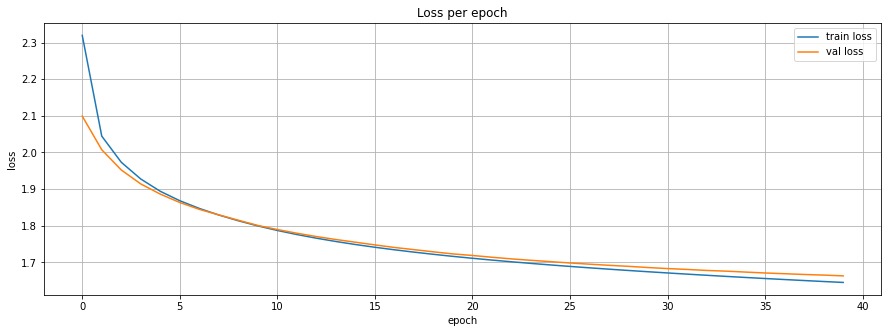

In [121]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

# yes_no

In [123]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, nnet_context_sgd.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 30.00%
Total time is: 0.27 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_noha

## Digits

In [124]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, nnet_context_sgd.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1

result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> TWO
result: four_fce65496_nohash_0      ==> FIVE
result: nine_ccea893d_nohash_0      ==> THREE
result: zero_f92e49f3_nohash_3      ==> THREE
result: four_ffbb695d_nohash_0      ==> FOUR
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FOUR
result: three_fce96bac_nohash_0     ==> FIVE
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> FIVE
result: nine_fbe51750_nohash_0      ==> ONE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> TWO
result: zero_f852895b_nohash_0      ==> ONE
result: one_fc2411fe_nohash_0       ==> ONE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> TWO
result: two_fce65496_nohash_0       ==> FIVE
------------------------------------------------------------
WER is: 80.00%
Total time is: 0.

Качество ухудшилось

# MyNewNNet + SGD + StepLR

In [133]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
newnnet_context_sgd = MyNewNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(newnnet_context_sgd.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(50):
    newnnet_context_sgd.train()
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = newnnet_context_sgd(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
    
    with torch.no_grad():
        newnnet_context_sgd.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
        val_out = newnnet_context_sgd(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    lr_scheduler.step()
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

Adjusting learning rate of group 0 to 1.0000e-03.
TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 2.3010
val loss is: 2.1204


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 2.0638
val loss is: 2.0229


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.9894
val loss is: 1.9665


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.9400
val loss is: 1.9256


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
loss is: 1.9026
val loss is: 1.8937


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
loss is: 1.8700
val loss is: 1.8692


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
loss is: 1.8563
val loss is: 1.8567


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
loss is: 1.8438
val loss is: 1.8451


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
loss is: 1.8325
val loss is: 1.8339


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-04.
loss is: 1.8221
val loss is: 1.8244


epoch 10:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-04.
loss is: 1.8100
val loss is: 1.8142


epoch 11:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-04.
loss is: 1.8052
val loss is: 1.8096


epoch 12:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-04.
loss is: 1.8007
val loss is: 1.8053


epoch 13:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-04.
loss is: 1.7963
val loss is: 1.8012


epoch 14:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-04.
loss is: 1.7920
val loss is: 1.7972


epoch 15:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-04.
loss is: 1.7866
val loss is: 1.7926


epoch 16:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-04.
loss is: 1.7845
val loss is: 1.7907


epoch 17:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-04.
loss is: 1.7825
val loss is: 1.7887


epoch 18:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-04.
loss is: 1.7805
val loss is: 1.7869


epoch 19:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-05.
loss is: 1.7786
val loss is: 1.7850


epoch 20:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-05.
loss is: 1.7760
val loss is: 1.7829


epoch 21:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-05.
loss is: 1.7750
val loss is: 1.7820


epoch 22:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-05.
loss is: 1.7740
val loss is: 1.7811


epoch 23:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-05.
loss is: 1.7731
val loss is: 1.7803


epoch 24:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-05.
loss is: 1.7722
val loss is: 1.7794


epoch 25:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-05.
loss is: 1.7709
val loss is: 1.7784


epoch 26:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-05.
loss is: 1.7704
val loss is: 1.7780


epoch 27:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-05.
loss is: 1.7700
val loss is: 1.7775


epoch 28:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-05.
loss is: 1.7695
val loss is: 1.7771


epoch 29:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-05.
loss is: 1.7691
val loss is: 1.7767


epoch 30:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-05.
loss is: 1.7684
val loss is: 1.7762


epoch 31:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-05.
loss is: 1.7682
val loss is: 1.7760


epoch 32:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-05.
loss is: 1.7680
val loss is: 1.7757


epoch 33:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-05.
loss is: 1.7677
val loss is: 1.7755


epoch 34:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8125e-06.
loss is: 1.7675
val loss is: 1.7753


epoch 35:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8125e-06.
loss is: 1.7672
val loss is: 1.7751


epoch 36:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8125e-06.
loss is: 1.7671
val loss is: 1.7750


epoch 37:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8125e-06.
loss is: 1.7670
val loss is: 1.7748


epoch 38:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8125e-06.
loss is: 1.7668
val loss is: 1.7747


epoch 39:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9063e-06.
loss is: 1.7667
val loss is: 1.7746


epoch 40:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9063e-06.
loss is: 1.7666
val loss is: 1.7745


epoch 41:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9063e-06.
loss is: 1.7665
val loss is: 1.7745


epoch 42:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9063e-06.
loss is: 1.7664
val loss is: 1.7744


epoch 43:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.9063e-06.
loss is: 1.7664
val loss is: 1.7743


epoch 44:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9531e-06.
loss is: 1.7663
val loss is: 1.7743


epoch 45:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9531e-06.
loss is: 1.7663
val loss is: 1.7742


epoch 46:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9531e-06.
loss is: 1.7662
val loss is: 1.7742


epoch 47:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9531e-06.
loss is: 1.7662
val loss is: 1.7742


epoch 48:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9531e-06.
loss is: 1.7662
val loss is: 1.7741


epoch 49:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.7656e-07.
loss is: 1.7661
val loss is: 1.7741
Time is: 4 min 26 sec


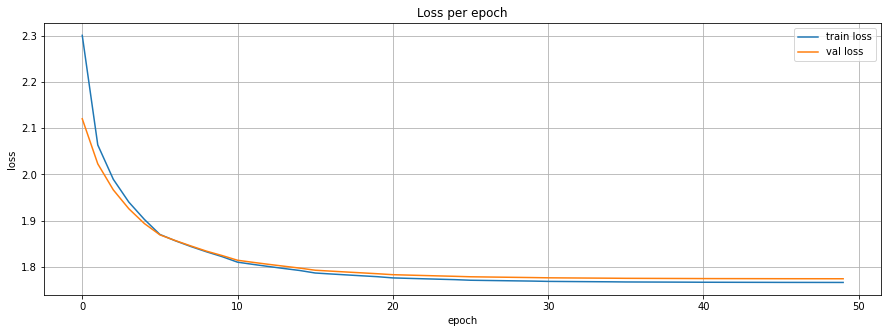

In [134]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [139]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

newnnet_context_sgd.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = newnnet_context_sgd.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.492



## yes_no

In [140]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, newnnet_context_sgd.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.34 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_noh

In [136]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, newnnet_context_sgd.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1

result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> TWO
result: four_fce65496_nohash_0      ==> TWO
result: nine_ccea893d_nohash_0      ==> FOUR
result: zero_f92e49f3_nohash_3      ==> THREE
result: four_ffbb695d_nohash_0      ==> TWO
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FOUR
result: three_fce96bac_nohash_0     ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: six_ffbb695d_nohash_0       ==> FIVE
result: nine_fbe51750_nohash_0      ==> ONE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> TWO
result: zero_f852895b_nohash_0      ==> ONE
result: one_fc2411fe_nohash_0       ==> ONE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> TWO
result: two_fce65496_nohash_0       ==> TWO
------------------------------------------------------------
WER is: 75.00%
Total time is: 1.28 se

# MyNNet + SGD + StepLR

In [146]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
nnet_context_sgd = MyNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nnet_context_sgd.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(50):
    nnet_context_sgd.train()
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet_context_sgd(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
    
    with torch.no_grad():
        nnet_context_sgd.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
        val_out = nnet_context_sgd(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    lr_scheduler.step()
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

Adjusting learning rate of group 0 to 1.0000e-03.
TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 2.3037
val loss is: 2.0806


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 2.0327
val loss is: 1.9927


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.9662
val loss is: 1.9429


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.9239
val loss is: 1.9085


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.8926
val loss is: 1.8815


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.8682
val loss is: 1.8596


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.8482
val loss is: 1.8423


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.8313
val loss is: 1.8275


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss is: 1.8168
val loss is: 1.8139


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.8039
val loss is: 1.8027


epoch 10:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7815
val loss is: 1.7848


epoch 11:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7795
val loss is: 1.7835


epoch 12:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7782
val loss is: 1.7822


epoch 13:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7769
val loss is: 1.7811


epoch 14:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7757
val loss is: 1.7799


epoch 15:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7745
val loss is: 1.7788


epoch 16:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7734
val loss is: 1.7777


epoch 17:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7722
val loss is: 1.7766


epoch 18:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
loss is: 1.7711
val loss is: 1.7756


epoch 19:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7700
val loss is: 1.7745


epoch 20:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7679
val loss is: 1.7730


epoch 21:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7676
val loss is: 1.7729


epoch 22:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7675
val loss is: 1.7728


epoch 23:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7674
val loss is: 1.7727


epoch 24:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7673
val loss is: 1.7726


epoch 25:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7672
val loss is: 1.7724


epoch 26:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7670
val loss is: 1.7723


epoch 27:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7669
val loss is: 1.7722


epoch 28:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
loss is: 1.7668
val loss is: 1.7721


epoch 29:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7667
val loss is: 1.7720


epoch 30:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7665
val loss is: 1.7720


epoch 31:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7664
val loss is: 1.7720


epoch 32:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7664
val loss is: 1.7719


epoch 33:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7664
val loss is: 1.7719


epoch 34:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7664
val loss is: 1.7719


epoch 35:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7664
val loss is: 1.7719


epoch 36:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7664
val loss is: 1.7719


epoch 37:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7664
val loss is: 1.7719


epoch 38:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.
loss is: 1.7664
val loss is: 1.7719


epoch 39:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 40:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 41:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 42:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 43:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 44:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 45:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 46:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 47:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 48:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-07.
loss is: 1.7663
val loss is: 1.7719


epoch 49:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-08.
loss is: 1.7663
val loss is: 1.7719
Time is: 3 min 44 sec


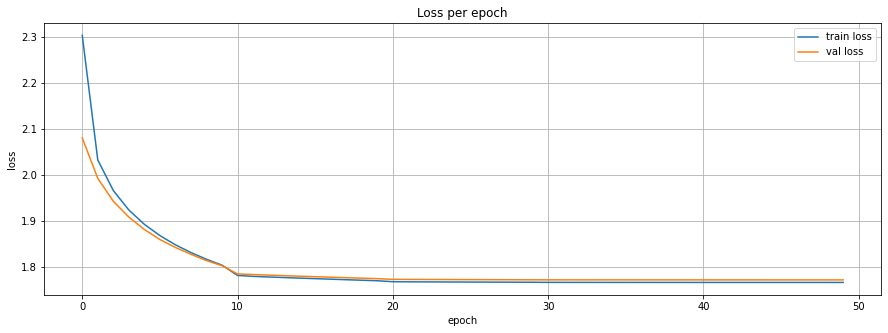

In [147]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [148]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet_context_sgd.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet_context_sgd.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.494



## yes_no

In [149]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, nnet_context_sgd.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.31 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_noh

## digits

In [150]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, nnet_context_sgd.cpu(), side_context, beam_threshold=beam)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1

result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> FIVE
result: nine_ccea893d_nohash_0      ==> FOUR
result: zero_f92e49f3_nohash_3      ==> THREE
result: four_ffbb695d_nohash_0      ==> FOUR
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FOUR
result: three_fce96bac_nohash_0     ==> FIVE
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> SIX
result: nine_fbe51750_nohash_0      ==> ONE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> ONE
result: one_fc2411fe_nohash_0       ==> ONE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> THREE
result: two_fce65496_nohash_0       ==> TWO
------------------------------------------------------------
WER is: 65.00%
Total time is: 1

# MyNormNNet + Adam + StepLR

In [156]:
class MyNormNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNormNNet, self).__init__()
        # params:

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [210]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
norm_nnet_context_sched = MyNormNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(norm_nnet_context_sched.parameters(), lr=0.01)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(30):
    norm_nnet_context_sched.train()
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = norm_nnet_context_sched(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
    
    with torch.no_grad():
        norm_nnet_context_sched.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
        val_out = norm_nnet_context_sched(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    lr_scheduler.step()
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

Adjusting learning rate of group 0 to 1.0000e-02.
TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
loss is: 1.7136
val loss is: 1.6163


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
loss is: 1.5757
val loss is: 1.5530


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
loss is: 1.5306
val loss is: 1.5223


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
loss is: 1.5034
val loss is: 1.5119


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
loss is: 1.4844
val loss is: 1.4993


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
loss is: 1.4256
val loss is: 1.4499


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
loss is: 1.4130
val loss is: 1.4454


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
loss is: 1.4054
val loss is: 1.4433


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
loss is: 1.3994
val loss is: 1.4410


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.
loss is: 1.3945
val loss is: 1.4397


epoch 10:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.
loss is: 1.3657
val loss is: 1.4191


epoch 11:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.
loss is: 1.3601
val loss is: 1.4186


epoch 12:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.
loss is: 1.3569
val loss is: 1.4179


epoch 13:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.
loss is: 1.3543
val loss is: 1.4173


epoch 14:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.
loss is: 1.3519
val loss is: 1.4170


epoch 15:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.
loss is: 1.3369
val loss is: 1.4079


epoch 16:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.
loss is: 1.3341
val loss is: 1.4075


epoch 17:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.
loss is: 1.3325
val loss is: 1.4075


epoch 18:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.
loss is: 1.3311
val loss is: 1.4072


epoch 19:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.
loss is: 1.3298
val loss is: 1.4071


epoch 20:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.
loss is: 1.3219
val loss is: 1.4026


epoch 21:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.
loss is: 1.3204
val loss is: 1.4024


epoch 22:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.
loss is: 1.3195
val loss is: 1.4024


epoch 23:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.
loss is: 1.3187
val loss is: 1.4024


epoch 24:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.
loss is: 1.3180
val loss is: 1.4023


epoch 25:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.
loss is: 1.3139
val loss is: 1.4003


epoch 26:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.
loss is: 1.3130
val loss is: 1.4002


epoch 27:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.
loss is: 1.3125
val loss is: 1.4002


epoch 28:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.
loss is: 1.3122
val loss is: 1.4003


epoch 29:   0%|          | 0/4511 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-04.
loss is: 1.3118
val loss is: 1.4002
Time is: 4 min 7 sec


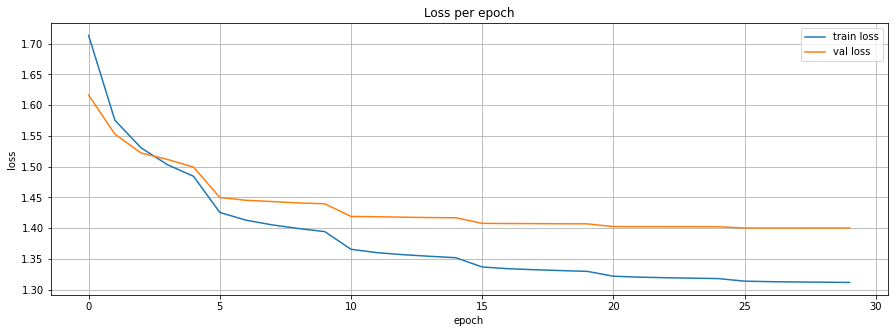

In [211]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [212]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

norm_nnet_context_sched.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(np.array([ftr])).float()
        output = norm_nnet_context_sched.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.579



## yes_no

In [213]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, norm_nnet_context_sched.cpu(), 
                   side_context, beam_threshold=beam, norm=True)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO


/tmp/ipykernel_375/1815615332.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))


result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 10.00%
Total time is: 0.39 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 10.00%
Tot

In [214]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, norm_nnet_context_sched.cpu(), 
                   side_context, beam_threshold=beam, norm=True)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1



/tmp/ipykernel_375/1815615332.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))


result: eight_daf230ac_nohash_0     ==> TWO
result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> TWO
result: nine_ccea893d_nohash_0      ==> ZERO
result: zero_f92e49f3_nohash_3      ==> ONE
result: four_ffbb695d_nohash_0      ==> THREE
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> FOUR
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> THREE
result: one_fc2411fe_nohash_0       ==> NINE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: two_fce65496_nohash_0       ==> TWO
------------------------------------------------------------
WER is: 65.00%
Total time is: 1.49 se

# MyNormNNet + Adam + ReduceLROnPlateau

In [251]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
norm_nnet_context_plateau = MyNormNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(norm_nnet_context_plateau.parameters(), lr=0.01)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, patience=2, verbose=True)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(30):
    norm_nnet_context_plateau.train()
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = norm_nnet_context_plateau(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
    
    with torch.no_grad():
        norm_nnet_context_plateau.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
        val_out = norm_nnet_context_plateau(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    lr_scheduler.step(val_l)
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7146
val loss is: 1.6094


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5753
val loss is: 1.5605


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5301
val loss is: 1.5357


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5025
val loss is: 1.5145


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4835
val loss is: 1.5049


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4697
val loss is: 1.4940


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4585
val loss is: 1.4938


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4493
val loss is: 1.4884


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4416
val loss is: 1.4872


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4353
val loss is: 1.4855


epoch 10:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4294
val loss is: 1.4832


epoch 11:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4243
val loss is: 1.4832


epoch 12:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4199
val loss is: 1.4808


epoch 13:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4158
val loss is: 1.4827


epoch 14:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4124
val loss is: 1.4791


epoch 15:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4090
val loss is: 1.4766


epoch 16:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4059
val loss is: 1.4770


epoch 17:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4031
val loss is: 1.4723


epoch 18:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4005
val loss is: 1.4727


epoch 19:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3982
val loss is: 1.4731


epoch 20:   0%|          | 0/4511 [00:00<?, ?it/s]

Epoch    21: reducing learning rate of group 0 to 1.0000e-03.
loss is: 1.3961
val loss is: 1.4726


epoch 21:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3359
val loss is: 1.4082


epoch 22:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3242
val loss is: 1.4057


epoch 23:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3204
val loss is: 1.4048


epoch 24:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3181
val loss is: 1.4042


epoch 25:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3163
val loss is: 1.4038


epoch 26:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3149
val loss is: 1.4035


epoch 27:   0%|          | 0/4511 [00:00<?, ?it/s]

Epoch    28: reducing learning rate of group 0 to 1.0000e-04.
loss is: 1.3137
val loss is: 1.4033


epoch 28:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3057
val loss is: 1.3997


epoch 29:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3043
val loss is: 1.3993
Time is: 4 min 6 sec


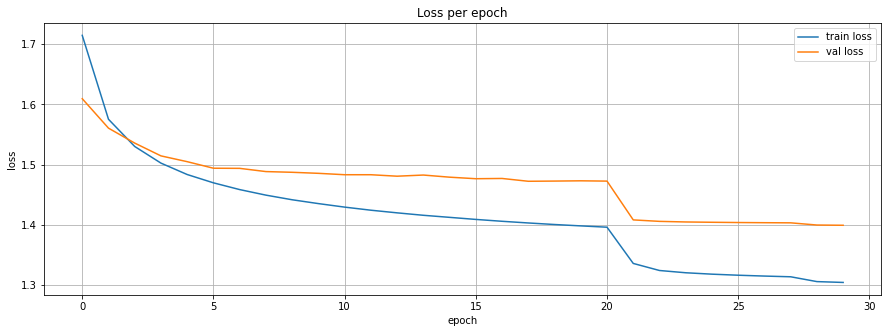

In [253]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [254]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

norm_nnet_context_plateau.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(np.array([ftr])).float()
        output = norm_nnet_context_plateau.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.581



## yes_no

In [255]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, norm_nnet_context_plateau.cpu(), 
                   side_context, beam_threshold=beam, norm=True)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO


/tmp/ipykernel_375/1815615332.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))


result: yes_39a6b995_nohash_0       ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.38 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> YES
------------------------------------------------------------
WER is: 30.00%
Tota

## digits

In [256]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, norm_nnet_context_plateau.cpu(), 
                   side_context, beam_threshold=beam, norm=True)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1

result: eight_daf230ac_nohash_0     ==> TWO


/tmp/ipykernel_375/1815615332.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))


result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> TWO
result: nine_ccea893d_nohash_0      ==> TWO
result: zero_f92e49f3_nohash_3      ==> ONE
result: four_ffbb695d_nohash_0      ==> THREE
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> ONE
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> THREE
result: nine_fbe51750_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> THREE
result: one_fc2411fe_nohash_0       ==> NINE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> TWO
result: two_fce65496_nohash_0       ==> ONE
------------------------------------------------------------
WER is: 80.00%
Total time is: 1.19 sec
----------------------------------------------

# MyNormNNet + Adam + StepLR + ReduceLROnPlateau

In [257]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list_context, device)

batch_size = 256

# training network model:
start = time.time() 
norm_nnet_context_2_sched = MyNormNNet(input_dim=(data_list_context[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
model = norm_nnet_context_2_sched
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, verbose=True)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.01, patience=2, verbose=True)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

loss_list = []
val_loss = []

print('TRAINIG STARTED...')
for epoch in range(30):
    model.train()
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = model(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
    
    with torch.no_grad():
        model.eval()
        val_xs = torch.tensor(data_set.valid[:, :-1], dtype=torch.float32).to(device)
        val_ys = torch.tensor(data_set.valid[:,-1].ravel(), dtype=torch.int64).to(device)
        val_out = model(val_xs)
        val_l = criterion(val_out, val_ys)
        val_loss.append(val_l.item())
        
    #lr_scheduler.step(val_l)
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    print('val loss is: {:.4f}'.format(val_l))
    
    if epoch < 20:
        scheduler2.step()
    else:
        scheduler1.step(val_l)
    
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

Adjusting learning rate of group 0 to 1.0000e-02.
TRAINIG STARTED...


epoch 0:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.7139
val loss is: 1.6268
Adjusting learning rate of group 0 to 1.0000e-02.


epoch 1:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5759
val loss is: 1.5560
Adjusting learning rate of group 0 to 1.0000e-02.


epoch 2:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5307
val loss is: 1.5310
Adjusting learning rate of group 0 to 1.0000e-02.


epoch 3:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.5031
val loss is: 1.5124
Adjusting learning rate of group 0 to 1.0000e-02.


epoch 4:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4839
val loss is: 1.5039
Adjusting learning rate of group 0 to 5.0000e-03.


epoch 5:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4252
val loss is: 1.4553
Adjusting learning rate of group 0 to 5.0000e-03.


epoch 6:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4124
val loss is: 1.4528
Adjusting learning rate of group 0 to 5.0000e-03.


epoch 7:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.4048
val loss is: 1.4508
Adjusting learning rate of group 0 to 5.0000e-03.


epoch 8:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3987
val loss is: 1.4489
Adjusting learning rate of group 0 to 5.0000e-03.


epoch 9:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3935
val loss is: 1.4458
Adjusting learning rate of group 0 to 2.5000e-03.


epoch 10:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3647
val loss is: 1.4236
Adjusting learning rate of group 0 to 2.5000e-03.


epoch 11:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3592
val loss is: 1.4226
Adjusting learning rate of group 0 to 2.5000e-03.


epoch 12:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3560
val loss is: 1.4216
Adjusting learning rate of group 0 to 2.5000e-03.


epoch 13:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3533
val loss is: 1.4213
Adjusting learning rate of group 0 to 2.5000e-03.


epoch 14:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3509
val loss is: 1.4206
Adjusting learning rate of group 0 to 1.2500e-03.


epoch 15:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3360
val loss is: 1.4092
Adjusting learning rate of group 0 to 1.2500e-03.


epoch 16:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3332
val loss is: 1.4087
Adjusting learning rate of group 0 to 1.2500e-03.


epoch 17:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3315
val loss is: 1.4085
Adjusting learning rate of group 0 to 1.2500e-03.


epoch 18:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3301
val loss is: 1.4082
Adjusting learning rate of group 0 to 1.2500e-03.


epoch 19:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3289
val loss is: 1.4082
Adjusting learning rate of group 0 to 6.2500e-04.


epoch 20:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3210
val loss is: 1.4025


epoch 21:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3195
val loss is: 1.4023


epoch 22:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3187
val loss is: 1.4023


epoch 23:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3179
val loss is: 1.4023
Epoch     4: reducing learning rate of group 0 to 6.2500e-05.


epoch 24:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3114
val loss is: 1.3983


epoch 25:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3101
val loss is: 1.3979


epoch 26:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3096
val loss is: 1.3977
Epoch     7: reducing learning rate of group 0 to 6.2500e-06.


epoch 27:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3085
val loss is: 1.3976


epoch 28:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3084
val loss is: 1.3975


epoch 29:   0%|          | 0/4511 [00:00<?, ?it/s]

loss is: 1.3083
val loss is: 1.3974
Epoch    10: reducing learning rate of group 0 to 6.2500e-07.
Time is: 4 min 7 sec


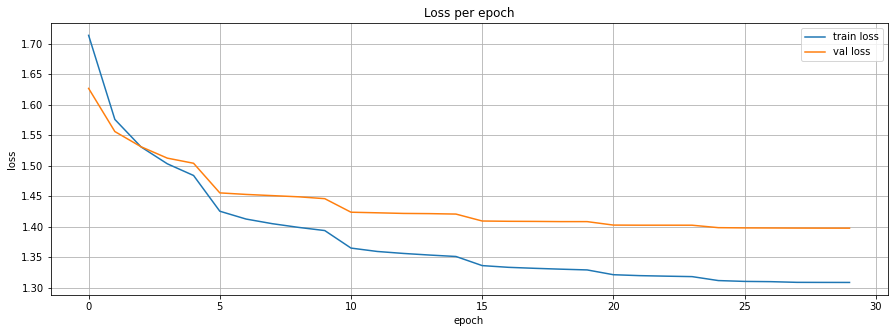

In [258]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

In [259]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

model.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(np.array([ftr])).float()
        output = model.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

  0%|          | 0/128315 [00:00<?, ?it/s]

Total frame accuracy is 0.581



## yes_no

In [260]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

for beam in [1, 3, 5, 10, 20]:
    print(f'Beam = {beam}\n')
    run_recognizer(records_data_dict, graph, model.cpu(), 
                   side_context, beam_threshold=beam, norm=True)
    print()
    print('##################################################')
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Beam = 1

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> NO
result: no_41474817_nohash_0        ==> NO


/tmp/ipykernel_375/1815615332.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))


result: yes_39a6b995_nohash_0       ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 30.00%
Total time is: 0.36 sec
------------------------------------------------------------

##################################################

Beam = 3

result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 20.00%
Total

## digits

In [261]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("lab2/data/digits/records")

for beam in [1, 5, 10, 20, 30, 50]:
    print(f'beam = {beam}')
    print()
    run_recognizer(records_data_dict, graph, model.cpu(), 
                   side_context, beam_threshold=beam, norm=True)
    print()
    print('##################################################')
    print()

  0%|          | 0/20 [00:00<?, ?it/s]

beam = 1

result: eight_daf230ac_nohash_0     ==> TWO


/tmp/ipykernel_375/1815615332.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))


result: eight_da584bc0_nohash_4     ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> TWO
result: nine_ccea893d_nohash_0      ==> TWO
result: zero_f92e49f3_nohash_3      ==> THREE
result: four_ffbb695d_nohash_0      ==> TWO
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> THREE
result: three_fce96bac_nohash_0     ==> FOUR
result: five_f852895b_nohash_0      ==> THREE
result: six_ffbb695d_nohash_0       ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fb2f3242_nohash_0       ==> THREE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: zero_f852895b_nohash_0      ==> THREE
result: one_fc2411fe_nohash_0       ==> NINE
result: one_ffa76c4a_nohash_0       ==> ONE
result: seven_fd32732a_nohash_0     ==> THREE
result: two_fce65496_nohash_0       ==> TWO
------------------------------------------------------------
WER is: 75.00%
Total time is: 1.74 sec
------------------------------------------

### **Ответ**:

Т.к. модель с контекстом побила Baseline, то новые модели будем сравнивать с ней.

Были испробованы различные способы для улучшения качества. Менялась архитектура (добавлен еще один полносвязный слой, батчнорм), менялся оптимизатор, применялись шедулеры. Но, к сожалению, сильно улучшить качество не удалось. Ниже примедены результаты работы моделей. Красным шрифтом выделены победители. При равных скорах предпочтение отдавалось модели попроще и с меньшим временем работы.

В целом можно заметить, что лишь добавление контекста уже сильно улучшило качество распознавания для датасета `yes_no`. С цифрами все оказалось сложнее. Думаю это связано с тем, что сам датасет сложнее. Поэтому более сложные модели лучше подходят для датасета с цифрами, в то время как на датасете `yes_no` качество просело. Тем неменее, удалось добиться снижения WER до 10% при условии beam = 1.

На датасете с цифрами удалось добиться нулевой ошибки при пороге beam = 50. Хотя на качество модели сиольное влияние оказывает начальная инициализация весов. При неоднократном перезапуске обучения результат обучения модели меняется.   

Ниже приведены результаты.

Качество на датасетах:  
***Yes_no***  
**1) beam = 1**  
* side_context = 2:
   * WER = 20%
   * Время = 0.39 сек
* MyNewNNet + Adam:
   * WER = 30%  
   * Время = 0.29 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.30 сек
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.29 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 30%  
   * Время = 0.27 сек
* MyNewNNet + SGD + StepLR:
   * WER = 20%  
   * Время = 0.34 сек
* MyNNet + SGD + StepLR:
   * WER = 20%  
   * Время = 0.31 сек
* <span style="color:red;font-weight:500;font-size:16px"> MyNormNNet + Adam + StepLR: </span> 
   * <span style="color:red;font-weight:500;font-size:16px">WER = 10%  </span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 0.39 сек  </span>
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.38 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 30%  
   * Время = 0.36 сек

   
**2) beam = 3**
* <span style="color:red;font-weight:500;font-size:16px">side_context = 2:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 10%</span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 0.37 сек</span>
* MyNewNNet + Adam:
   * WER = 20%  
   * Время = 0.36 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 0.29 сек
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.25 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 30%  
   * Время = 0.30 сек
* MyNewNNet + SGD + StepLR:
   * WER = 30%  
   * Время = 0.31 сек
* MyNNet + SGD + StepLR:
   * WER = 20%  
   * Время = 0.26 сек
* MyNormNNet + Adam + StepLR:
   * WER = 10%  
   * Время = 0.69 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 30%  
   * Время = 0.42 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.34 сек

**3) beam = 5**
* <span style="color:red;font-weight:500;font-size:16px">side_context = 2:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 0%</span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 0.34 сек</span>
* MyNewNNet + Adam:
   * WER = 20%  
   * Время = 0.39 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 0.40 сек
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.35 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.34 сек
* MyNewNNet + SGD + StepLR:
   * WER = 30%  
   * Время = 0.43 сек
* MyNNet + SGD + StepLR:
   * WER = 20%  
   * Время = 0.41 сек
* MyNormNNet + Adam + StepLR:
   * WER = 10%  
   * Время = 0.51 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 0%  
   * Время = 0.48 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.42 сек

**4) beam = 10**
* <span style="color:red;font-weight:500;font-size:16px">side_context = 2:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 0%</span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 0.46 сек</span>
* MyNewNNet + Adam:
   * WER = 0%  
   * Время = 0.66 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 0.56 сек
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 0.43 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 30%  
   * Время = 0.49 сек
* MyNewNNet + SGD + StepLR:
   * WER = 20%  
   * Время = 0.62 сек
* MyNNet + SGD + StepLR:
   * WER = 10%  
   * Время = 0.50 сек
* MyNormNNet + Adam + StepLR:
   * WER = 10%  
   * Время = 0.72 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 0.75 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.66 сек

**5) beam = 20**
* <span style="color:red;font-weight:500;font-size:16px">side_context = 2:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 0%</span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 0.65 сек</span>
* MyNewNNet + Adam:
   * WER = 0%  
   * Время = 0.77 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 0%  
   * Время = 0.75 сек
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 0.59 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 0.68 сек
* MyNewNNet + SGD + StepLR:
   * WER = 20%  
   * Время = 0.84 сек
* MyNNet + SGD + StepLR:
   * WER = 10%  
   * Время = 0.82 сек
* MyNormNNet + Adam + StepLR:
   * WER = 10%  
   * Время = 0.93 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 0.97 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 1.13 сек
  

 ***Digits***  
**1) beam = 1**
* <span style="color:red;font-weight:500;font-size:16px">side_context = 2:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 65%</span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 1.13 сек</span>
* MyNewNNet + Adam:
   * WER = 80%  
   * Время = 1.20 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 80%  
   * Время = 1.06 сек
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 75%  
   * Время = 1.04 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 80%  
   * Время = 0.98 сек
* MyNewNNet + SGD + StepLR:
   * WER = 75%  
   * Время = 1.28 сек
* MyNNet + SGD + StepLR:
   * WER = 65%  
   * Время = 1.49 сек
* MyNormNNet + Adam + StepLR:
   * WER = 65%  
   * Время = 1.49 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 80%  
   * Время = 1.19 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 75%  
   * Время = 1.74 сек

**2) beam = 5**
* side_context = 2:
   * WER = 55%
   * Время = 1.92 сек
* MyNewNNet + Adam:
   * WER = 55%  
   * Время = 2.41 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 50%  
   * Время = 2.38 сек
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 50%  
   * Время = 2.10 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 50%  
   * Время = 2.41 сек
* <span style="color:red;font-weight:500;font-size:16px">MyNewNNet + SGD + StepLR:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 45% </span> 
   * <span style="color:red;font-weight:500;font-size:16px">Время = 2.66 сек</span>
* MyNNet + SGD + StepLR:
   * WER = 50%  
   * Время = 2.36 сек
* MyNormNNet + Adam + StepLR:
   * WER = 50%  
   * Время = 2.58 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 55%  
   * Время = 2.29 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 55%  
   * Время = 2.66 сек
  
**3) beam = 10**
* <span style="color:red;font-weight:500;font-size:16px">side_context = 2:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 25%</span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 3.61 сек</span>
* MyNewNNet + Adam:
   * WER = 30%  
   * Время = 4.85 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 35%  
   * Время = 5.76 сек
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 25%  
   * Время = 3.05 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 25%  
   * Время = 3.85 сек
* MyNewNNet + SGD + StepLR:
   * WER = 35%  
   * Время = 4.76 сек
* MyNNet + SGD + StepLR:
   * WER = 35%  
   * Время = 3.86 сек
* MyNormNNet + Adam + StepLR:
   * WER = 30%  
   * Время = 4.38 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 40%  
   * Время = 4.27 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 40%  
   * Время = 5.04 сек
   
**4) beam = 20**
* side_context = 2:
   * WER = 10%
   * Время = 5.52 сек
* MyNewNNet + Adam:
   * WER = 10%  
   * Время = 7.06 сек
* <span style="color:red;font-weight:500;font-size:16px">MyNewNNet + Adam + ReduceLROnPlateau:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 5%  </span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 8.94 сек</span>
* MyNNet + Adam + ReduceLROnPlateau:
   * WER = 15%  
   * Время = 5.58 сек
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 15%  
   * Время = 5.80 сек
* MyNewNNet + SGD + StepLR:
   * WER = 15%  
   * Время = 7.97 сек
* MyNNet + SGD + StepLR:
   * WER = 15%  
   * Время = 6.55 сек
* MyNormNNet + Adam + StepLR:
   * WER = 10%  
   * Время = 7.39 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 7.18 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 20%  
   * Время = 7.54 сек
   
**5) beam = 30**
* side_context = 2:
   * WER = 10%
   * Время = 6.99 сек
* MyNewNNet + Adam:
   * WER = 10%  
   * Время = 8.21 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 5%  
   * Время = 8.37 сек
* <span style="color:red;font-weight:500;font-size:16px">MyNNet + Adam + ReduceLROnPlateau:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 5%  </span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 7.02 сек</span>
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 8.37 сек
* MyNewNNet + SGD + StepLR:
   * WER = 10%  
   * Время = 8.72 сек
* MyNNet + SGD + StepLR:
   * WER = 10%  
   * Время = 7.37 сек
* MyNormNNet + Adam + StepLR:
   * WER = 10%  
   * Время = 11.69 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 8.88 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 15%  
   * Время = 9.55 сек

   
**6) beam = 50**
* side_context = 2:
   * WER = 15%
   * Время = 7.99 сек
* MyNewNNet + Adam:
   * WER = 10%  
   * Время = 10.23 сек
* MyNewNNet + Adam + ReduceLROnPlateau:
   * WER = 5%  
   * Время = 10.08 сек
* <span style="color:red;font-weight:500;font-size:16px">MyNNet + Adam + ReduceLROnPlateau:</span>
   * <span style="color:red;font-weight:500;font-size:16px">WER = 0%  </span>
   * <span style="color:red;font-weight:500;font-size:16px">Время = 7.66 сек</span>
* MyNNet + SGD + ReduceLROnPlateau:
   * WER = 5%  
   * Время = 10.62 сек
* MyNewNNet + SGD + StepLR:
   * WER = 5%  
   * Время = 10.42 сек
* MyNNet + SGD + StepLR:
   * WER = 5%  
   * Время = 11.35 сек
* MyNormNNet + Adam + StepLR:
   * WER = 5%  
   * Время = 12.09 сек
* MyNormNNet + Adam + ReduceLROnPlateau:
   * WER = 15%  
   * Время = 12.41 сек 
* MyNormNNet + Adam + StepLR + ReduceLROnPlateau:
   * WER = 10%  
   * Время = 11.51 сек